# **Richter's Predictor: Modeling Earthquake Damage - Data Cleaning and Exploration**

<img src="https://earth.stanford.edu/sites/default/files/styles/1160_wide_scaled_/public/media/earthquake_nepal_simcseaflickr_17290940465_eebf3ff835_k.jpg?itok=zlGUK3II" alt="Destruction after 2015 Gorkha earthquake in Nepal" width="1000" class="center"/>

## Introduction & Outline

In 2015, a 7.8-magnitude earthquake in Nepal, also called the Gorkha earthquake, killed about 9,000 people, injured many thousands more, and damaged or destroyed more than 600,000 buildings in Kathmandu and other nearby cities. Based on aspects of building location and construction, our goal is to predict the level of damage to buildings caused by the earthquake. Predicting the grade of damage could show which types of buildings are particularly vulnerable. This knowledge could help adapt the design of buildings to better withstand future earthquakes in Nepal and around the world. The data we are going to use for this project was collected through surveys commissioned by the National Planning Commission Secretariat of Nepal. It is one of the largest post-disaster datasets ever collected. Overall, we use 43 columns and 762106 rows from this dataset. The columns and which kind of information they hold are described in the table below.

The whole project is separated in three major steps each documented in its own notebook. Additionally, you find one notebook that visualizes the geospatial data we have. Here is a quick overview:
- 01_data_clean
- 02_feature_engineering
- 03_prediction
- 04_geo_visualisation

The first three notebooks build on each other, while the fourth is standing on its own.

In the beginning of all notebooks you find a short overview over its contents. Here is what happens in this notebook:
- Intoduction & Outline
- Import Libraries & Setup
- Data Overview & Preparation
    - Hypotheses
    - Loading & Merging Data
    - Data Preparation
    - Train-Test-Split
    - Pandas Profiling
    - Summary
- Exploratory Data Analysis
    - Target Variable
    - Hypotheses Exploration I
    - Exploration of Secondary Use Variables
    - Exploration of Categorical Variables by Grade of Damage
    - Exploration of Numerical Variables by Grade of Damage
    - Outlier analysis
    - Hypotheses Exploration II
- Final Data Clean
    
    
    



## Import Libraries & Setup

At first, we will load all the necessary libraries, that we will use to conduct the analysis.

In [32]:
# First we load all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

import matplotlib            
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['figure.figsize'] = [6.0, 4.0]
#plt.rcParams['figure.dpi'] = 140

RSeed = 42

## Data Overview & Preparation

For your convenience, below you find a table with all the variables (columns) that are present in our dataset. For each column you find the variable name, a description of the content, and the data type.

In [33]:
#import pandas as pd
#pd.set_option('display.max_colwidth', None)
#data_documentation = pd.read_csv("data/Data_Documentation.csv", sep = ";")
#data_documentation

**Note:** The information in which geographical region the building is located is contained in the variables district_id (level 1), vdcmun_id (level 2) and ward_id (level 3). Level 1 for the largest and level 3 for the most specific sub-region.

### Hypotheses

Based on the available columns, we can make initial hypotheses that are interesting in terms of the degree of damage caused by the earthquake.

- The more floors (count_floors_pre_eq) the more damage.
- The heigher the building (height_ft_pre_eq) the more damage.
- The superstructure (all superstructure variables) used correlates with the grade of damage.
- The age of the buildings (age_building) is related to the degree of damage.
- The larger the foundation area of the building (plinth_area_sq_ft), the more stable it is.

Later, we will take a look at the data and check our assumptions. Now we will load and merge the data and delete columns that at first glance are not of interest for our project.

### Loading and Merging the Data

The raw data is seperated into two files. We load both files and merge them togehter into a single dataframe.

In [34]:
# Load data
csv_building_ownership_and_use = pd.read_csv("data/raw/csv_building_ownership_and_use.csv")
csv_building_structure = pd.read_csv("data/raw/csv_building_structure.csv")

# Merge data
df = pd.merge(csv_building_ownership_and_use, csv_building_structure, on=['building_id'], suffixes=('', '_y'))
df = df[df.columns.drop(list(df.filter(regex='_y')))]

We simply use the building ID which can be found in both raw tables in order to merge the data. To be on the safe side we keep all columns in the merged dataset (outer-join) and remove duplicated columns with the suffix "y" after merging.

### Data Preparation
At first we need to get a overview of the data to see where data cleaning is needed.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762106 entries, 0 to 762105
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             762106 non-null  int64  
 1   district_id                             762106 non-null  int64  
 2   vdcmun_id                               762106 non-null  int64  
 3   ward_id                                 762106 non-null  int64  
 4   legal_ownership_status                  762106 non-null  object 
 5   count_families                          762104 non-null  float64
 6   has_secondary_use                       762096 non-null  float64
 7   has_secondary_use_agriculture           762106 non-null  int64  
 8   has_secondary_use_hotel                 762106 non-null  int64  
 9   has_secondary_use_rental                762106 non-null  int64  
 10  has_secondary_use_institution           7621

#### Summary:
- Overall, the dataframe comprises 41 columns and 762106. 
- Most of the variables are of type object or integer.
- We have multiple vars that contain information about "secondary use" and the used "superstructure". Later on, we will explore these variables in more detail.
- As we can see from above the following variables contain a few missing values:
    - count_families
    - has_secondary_use
    - position
    - plan_configuration
    - damage_grade
    - technical_solution_proposed
- We will drop the rows with missing values.     
- Also, the columns that contain "post" earthquake information are not important for our analysis. Therefore, we will delete these columns.


In [36]:
# Drop columns with no relevancy for our analysis
df = df[df.columns.drop(list(df.filter(regex='_post_')))]

# Drop rows with missings in all columns
df.dropna(inplace=True)

### Train-Test Split

Now, we will split our data into a train and test dataset. The train dataset contains the data we will preprocess for our model and the test data will only be used in the very end to validate our model. The test data will be kept out of all preprocessing steps and data exploration in order to prevent data leakage (using data/knowledge from the test set for prediction that we should not have). This way we can later simulate how our model predicts "unknown" cases. 

In [37]:
X = df.copy() 
y = X.pop("damage_grade")

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, 
                                                    random_state=RSeed, stratify=y) 
# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 754472 samples.
Testing set has 7621 samples.


In [39]:
# Merge X_train and y_train 
df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1).copy()

In [40]:
#X_test.to_csv("data/test/X_test.csv")
#y_test.to_csv("data/test/y_test.csv")

We took 1% of our data (7621 observations) and saved them for later model evaluation. 

### Exploratory Data Analysis with Pandas Profiling
Pandas profiling generates profile reports from a DataFrame. It helps to get a first overview over the data for a quick preliminary data analysis.

In [41]:
#Run Pandas Profiling
#profile = ProfileReport(df)
#profile

[Click here for a preloaded version of the pandas data profile.](data_profile/profile_data_exploration.html)

**Profiling Report vorladen und Link updaten!!!**

#### Summary

- We can see that:
    - the variables "age_building", "base_area_q_ft" and "height_ft_pre_eq" are right skewed.
    - there are no obvious missings in the data.


## Exploratory Data Analysis

### Target variable

Now that we have an initial overview of the data, we will focus on our target in more detail. Overall, the variables "damage_grade" and "technical_solution_proposed" could both be used as target variable. At next, we will explore both in more depth and decide which one we eventually will use.

In [42]:
df.technical_solution_proposed.value_counts()

Reconstruction    465543
Major repair      128086
Minor repair      109497
No need            51346
Name: technical_solution_proposed, dtype: int64

In [43]:
# Convert the technical_solution_proposed variable to an integer to calculate the correlation between this variable and the damage_grade.
cleanup_nums = {"technical_solution_proposed":  {"No need": 0, "Minor repair": 1, "Major repair": 2, "Reconstruction": 3}}
df = df.replace(cleanup_nums)

In [44]:
# Convert damage_grade variable to an integer to calculate the correlation between this variable and technical_solution_proposed.
df["damage_grade"] = df.damage_grade.str.replace('Grade ', '')
df["damage_grade"] = df.damage_grade.astype('int')

In [45]:
corr = np.corrcoef(df.technical_solution_proposed, df.damage_grade) 
print(f'Pearsons correlation: {corr[1][0].round(2)}')


Pearsons correlation: 0.9


#### Summary
- Both strongly correlated. Therefore, it shouldn't really matter which one we choose. Since the degree of damage is a more objective measure, we will choose it as our target.

Now, we will plot the distribution of our target variable "damage_grade"

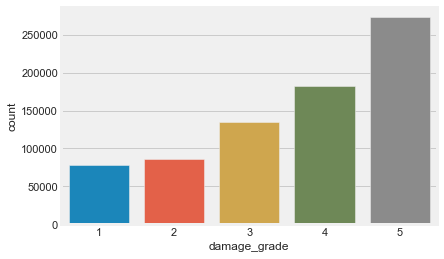

In [46]:
sns.countplot(x='damage_grade', data=df);

- Summary:
    - The plot above shows the distribution of the target variable.
    - Overall, most buildings have major damage.
    - The target classes are quite imbalanced. Therefore, we will have to use some over- and undersampling strategies later on to take care of this.
    - Further, for our analysis, 5 classes are probably too much. Later on, we will create 3 classes and explore which class combinations ake the most sense.

### Hypotheses Exploration I

Now we come back to the hypotheses we made at the beginning. A good starting point to explore these is to use a heat map that shows the correlation between the degree of damage and the features.

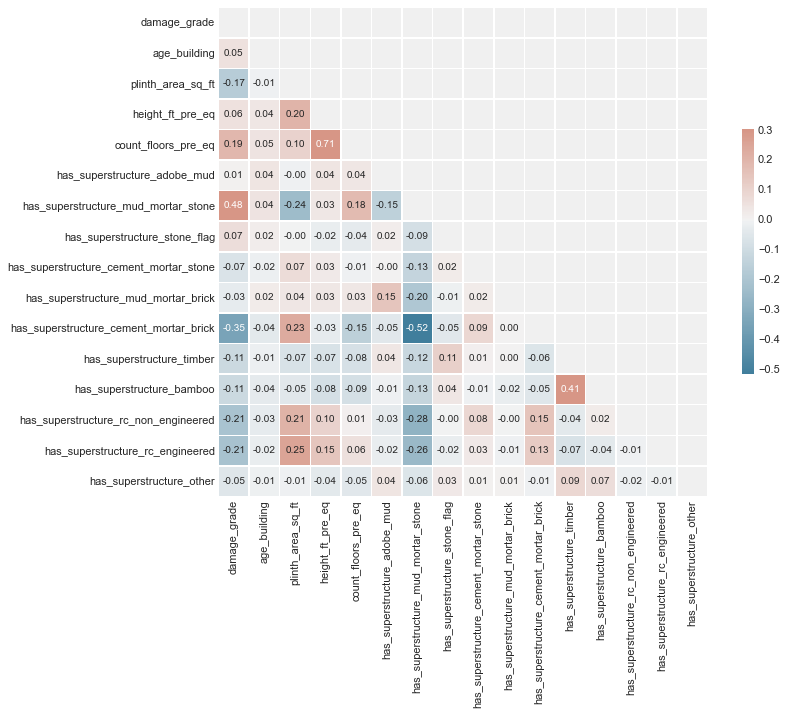

In [47]:
# Compute the correlation matrix of the target variable and selected features

vars_selected = ['damage_grade',
                 'age_building',
                 'plinth_area_sq_ft',
                 'height_ft_pre_eq',
                 'count_floors_pre_eq',
                 'has_superstructure_adobe_mud',
                 'has_superstructure_mud_mortar_stone',
                 'has_superstructure_stone_flag',
                 'has_superstructure_cement_mortar_stone',
                 'has_superstructure_mud_mortar_brick',
                 'has_superstructure_cement_mortar_brick',
                 'has_superstructure_timber',
                 'has_superstructure_bamboo',
                 'has_superstructure_rc_non_engineered',
                 'has_superstructure_rc_engineered',
                 'has_superstructure_other']

corr = df[vars_selected].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f');

### Summary
- The heat map shows:
    - That the superstructures rc_engineered, rc_non_engineered, cement_mortar_brick are moderate negatively correlated with the grade of damage. In other words, the grade of damage seems to be lower if the structure of the building is one of the aforementioned.
    - The age of the building does not seem to be correlated with the grade of the damage. This does not support the hypothesis that the older the building, the greater the damage.
    - Height seems not to be correlated with grade of damage.
    - The area of the buildings seems to be moderate negatively associated with the grade of damage. 
    
- It is important to note that this heat map only gives an initial overview. We need to dig deeper into the data and clean it before we can make a definitive statement about our hypotheses.     

### Exploration of Secondary Use Variables

Next, we will examine the secondary use variables. How many buildings have secondary uses? Are there buildings that have multiple uses? What type of secondary use is the most common? We will answer all of these questions below. Lets start with the how many buildings have secondary uses.

In [48]:
# Select columns that contain "has_secondary_use_" in column name
secondary_use_columns = df.filter(regex='has_secondary_use_')

In [49]:
# Sum of how many buldings have been used more than once

df["secondary_sum"] = secondary_use_columns.sum(axis='columns')

df["secondary_sum"].value_counts()

0    663061
1     90073
2      1338
Name: secondary_sum, dtype: int64

It can be seen that most buildings have no secondary use and 91411 have one secondary use. Of these, 90073 buildings have one secondary use and 1338 have two secondary uses.

Now we will continue to focus on the buildings that have secondary uses.

In [50]:
# Reversing 'one-hot' encoding
def get_second(row):
    for c in secondary_use_columns:
        if row[c]==1:
            return c

In [51]:
# Apply get_structure function:
secondary = secondary_use_columns.apply(get_second, axis=1)

In [52]:
# Fillna in secondary_use col
secondary = secondary.fillna("no_secondary_use")

In [53]:
# Rename rows of column "super_structure"
secondary = secondary.str.replace('has_secondary_use_', '')

secondary.head()
secondary.value_counts()

no_secondary_use    663061
agriculture          54206
hotel                26458
rental                6236
other                 2049
industry               883
institution            876
school                 318
health_post            171
gov_office             140
use_police              74
dtype: int64

In [54]:
secondary_use = pd.DataFrame(secondary, columns = ["secondary_use"])

In [55]:
# Concat secondary use with original df
df = pd.concat([df,secondary_use], axis=1)


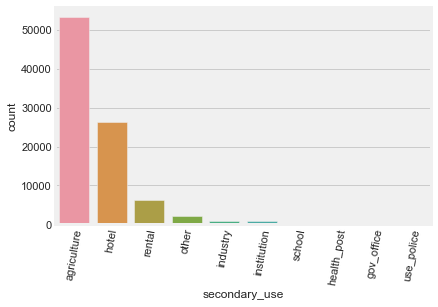

In [56]:
# Filter buildings that have one secondary use
df_secondary_use_one = df[df["secondary_sum"] == 1]

# Plot buildings with one secondary use
sns.countplot(x=df_secondary_use_one["secondary_use"], order = df_secondary_use_one["secondary_use"].value_counts().index)
plt.xticks(rotation=80);

As we can see, most of the buildings are used either as agriculture, hotel or for rent.

Lets continue with buildings that have two secondary uses.

In [57]:
# Filter buildings that have 2 secondary use
df_secondary_use_two = df[df["secondary_sum"] == 2]

In [58]:
# Select columns that contain "secondary" in column name
df_secondary_two_selected = df_secondary_use_two.filter(regex='secondary')

# Drop columns that are not needed
df_secondary_two_selected = df_secondary_two_selected.drop(columns = ['has_secondary_use', 'secondary_use', 'secondary_sum'])

In [59]:
# Add uses in column "combination" 
results = pd.DataFrame(columns=['Original_Index', 'Combination'])
for index, row in df_secondary_two_selected.iterrows():
    lst = []
    for col, i in df_secondary_two_selected.iteritems():   
        if row[col] == 1:
            lst.append(col)
    str_result = ("/".join(lst)).replace('has_secondary_use_', '')
    result_row = {'Original_Index': index, 'Combination': str_result}
    results = results.append(result_row, ignore_index=True)  


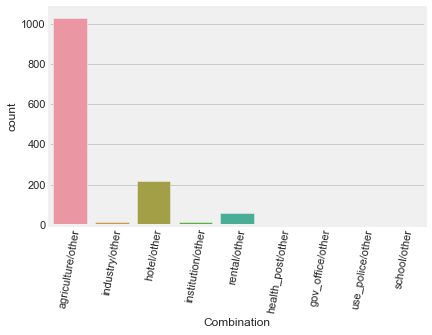

In [60]:
# Plot buildings with one secondary use

sns.countplot(x='Combination', data=results)
plt.xticks(rotation=80);

Overall, buildings that have two secondary uses have always "other" as second secondary use.

### Exploration of Categorical Variables by Grade of Damage

At next we have a closer look at categorical variables by grade of damage using countplots.

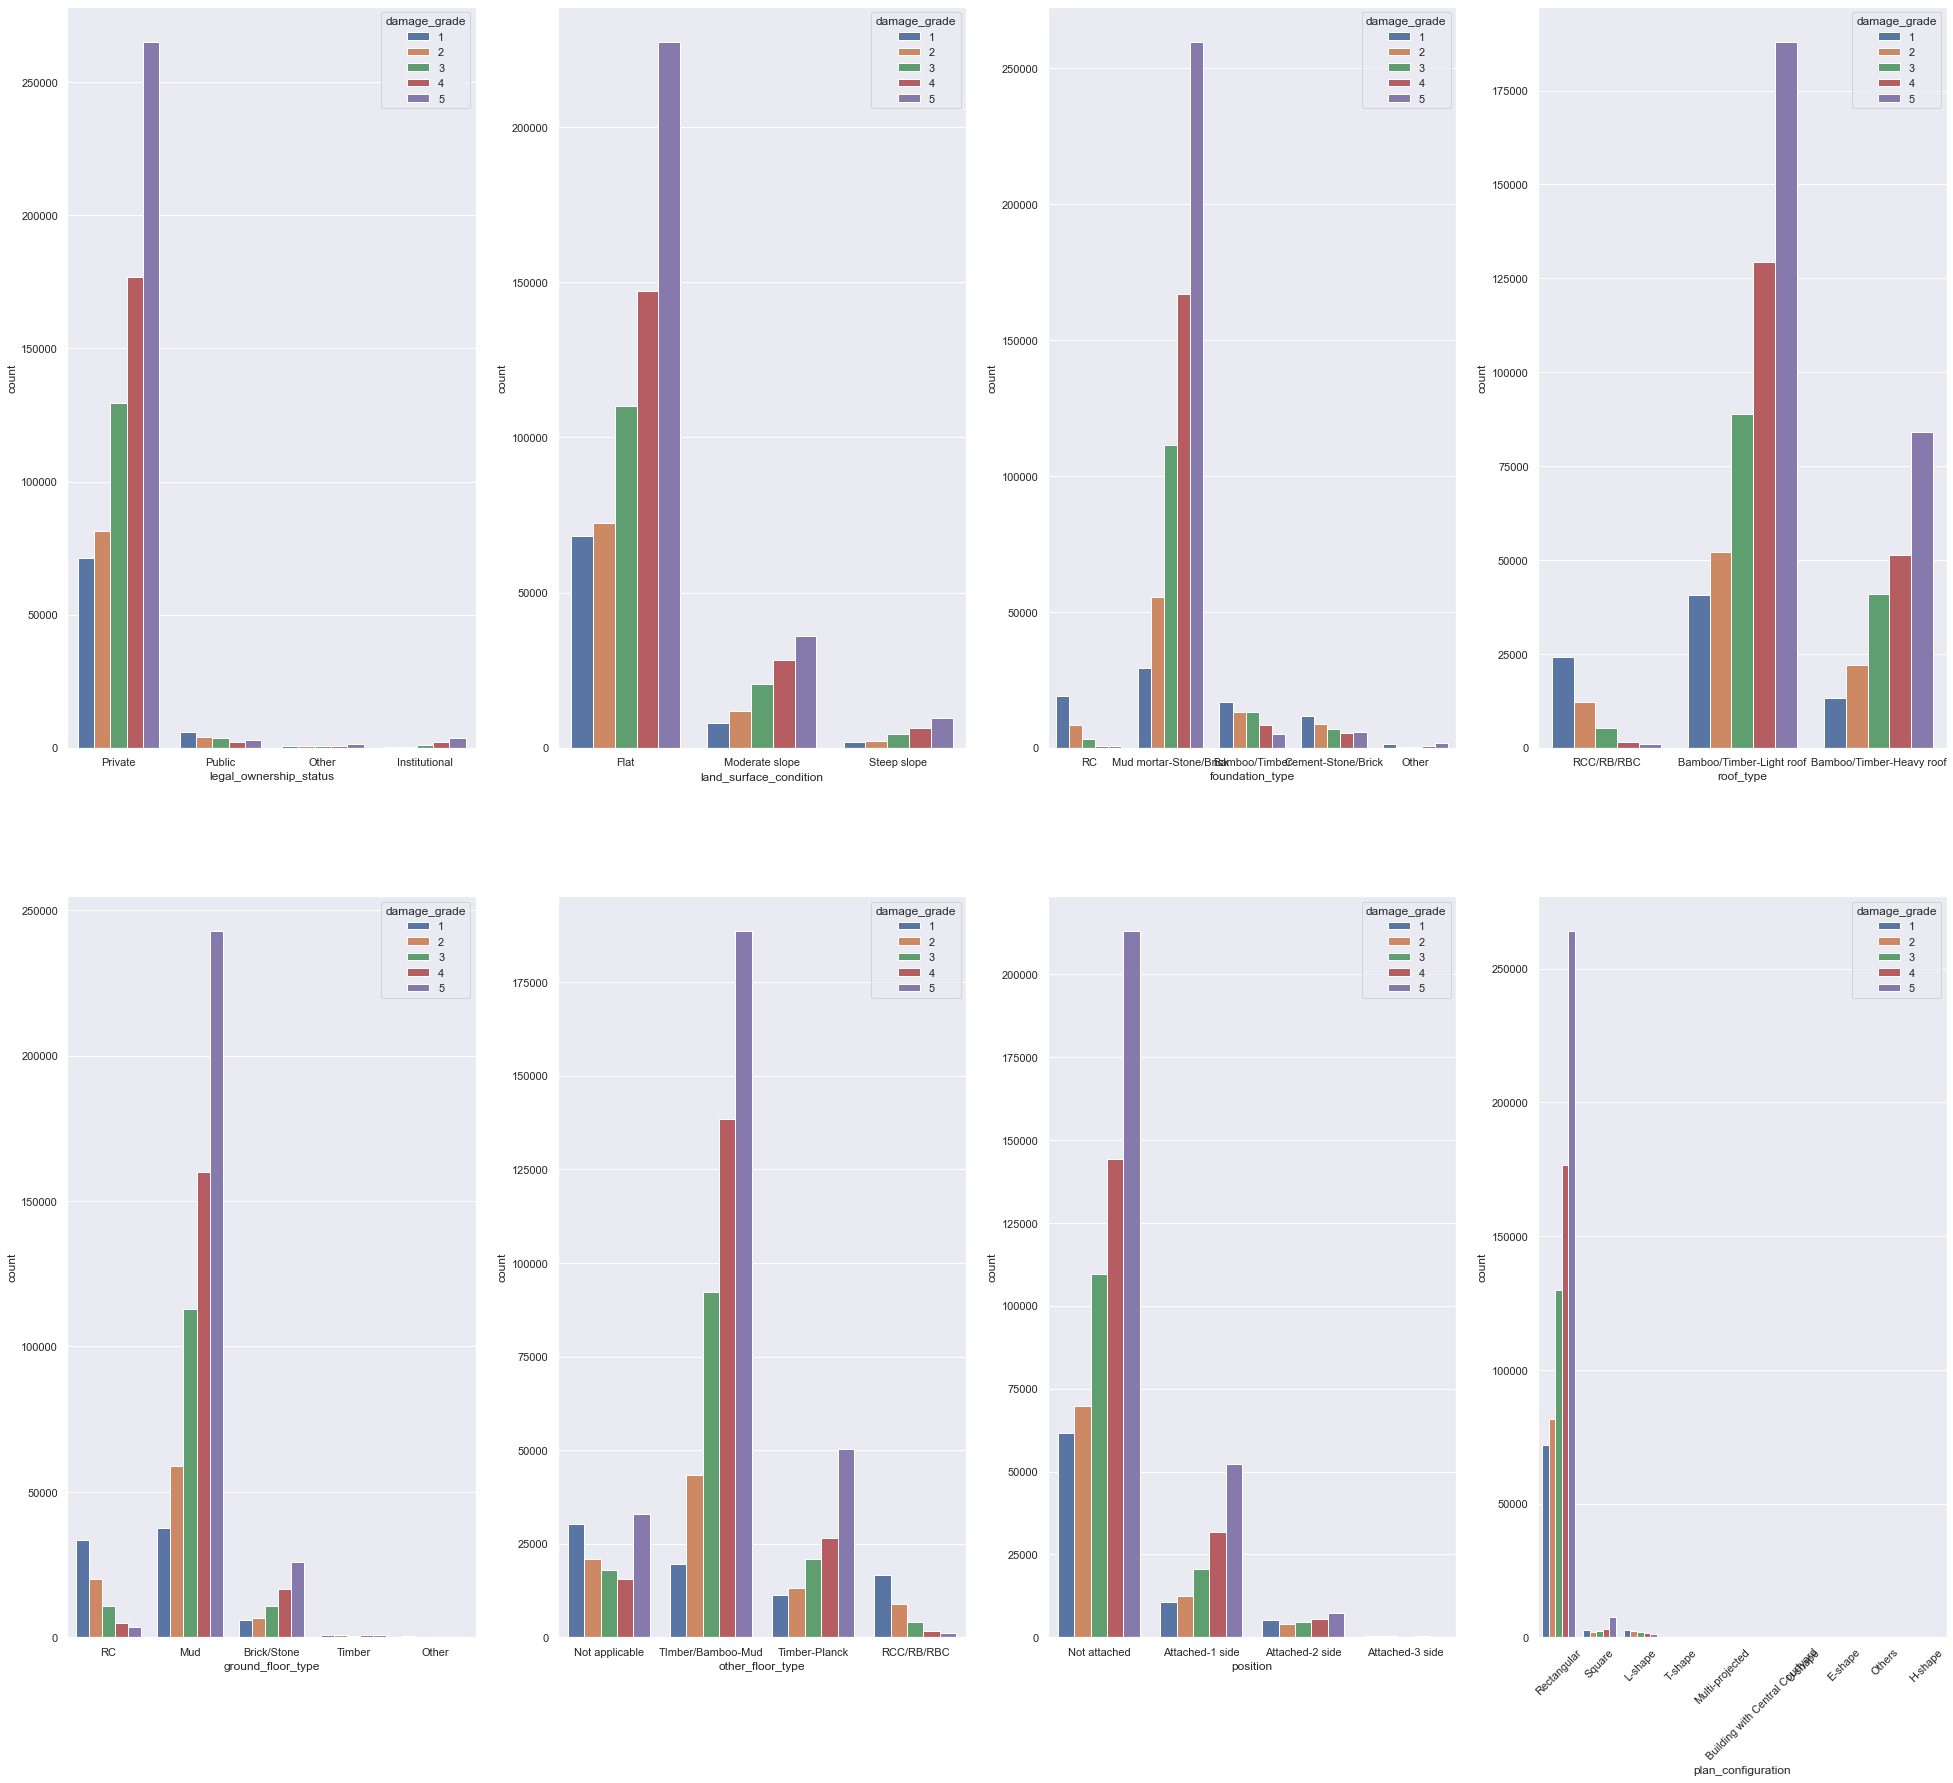

In [61]:
# Select variables of type object
countplot_columns = list(df.columns[df.dtypes==object])


# Countplot of selected variables by grade of damage
sns.set(rc={"figure.figsize":(30, 30)}) 
fig, axes = plt.subplots(ncols=4, nrows=2)

for col, ax in zip(df[countplot_columns], axes.flat):
    sns.countplot(x = df[col], hue = df["damage_grade"], ax = ax) # , dodge=False,
    plt.xticks(rotation=45) # does not work; why?
plt.show()

#### Summary

- Interestingly, a foundation, ground floor, roof or other floors of the type "RC" (reinforced concrete) mostly show level 1 damage. The other superstructures used tend to have higher levels of damage. 

### Outlier analysis

Because outliers can greatly affect our analysis, we will examine potential outliers in more detail and eventually exclude them from our data. Based on the pandas profiling we did at the beginning, we already have an idea of variables with potential outliers. The next step is to plot these variables using histograms.

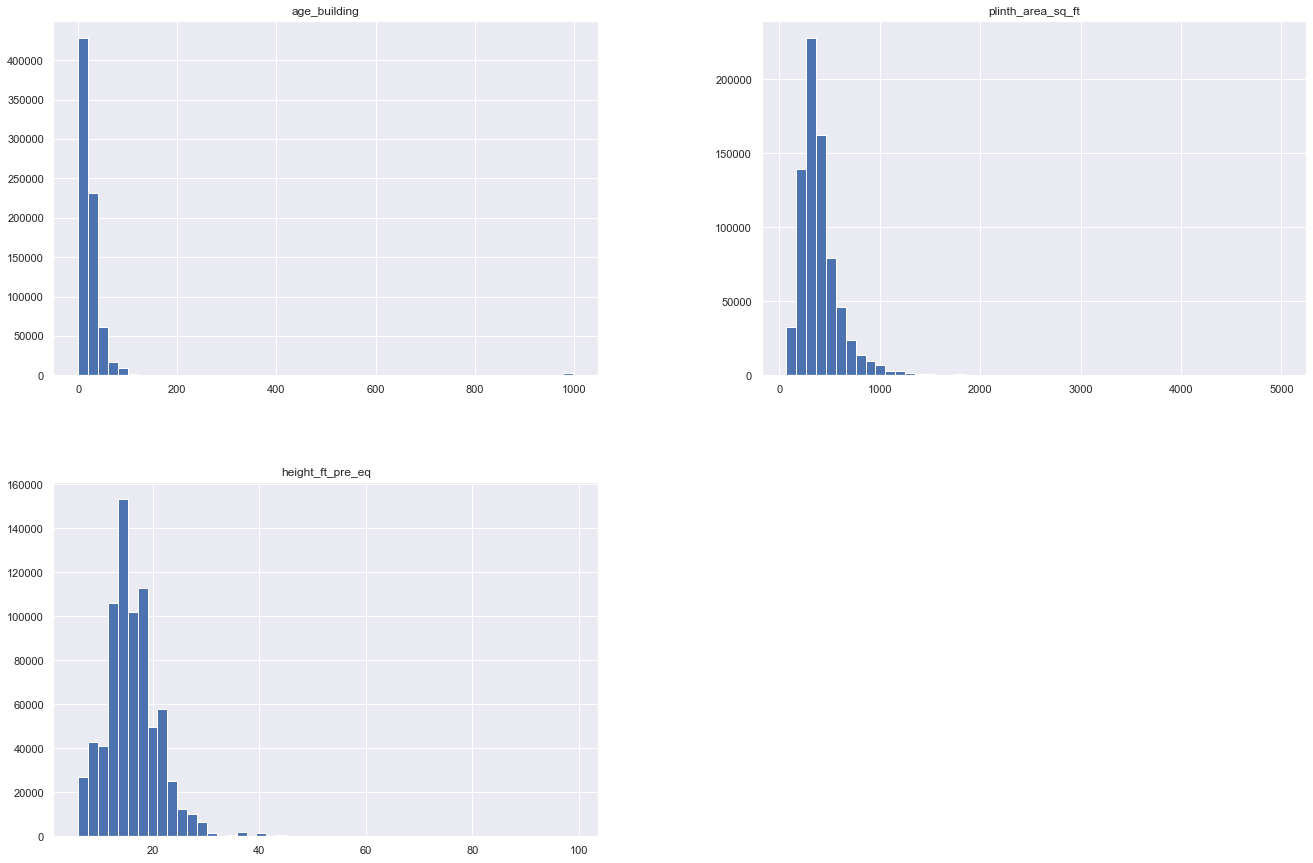

In [62]:
# Selecting the variables we want to look at in more detail

columns_histogram=["age_building", "plinth_area_sq_ft", "height_ft_pre_eq"]

# Plotting of Histograms
df[columns_histogram].hist(bins=50, figsize = (20,15))
plt.show()

##### Summary
- All of the variables presented above appear to contain outliers, as they are quite right skewed.

First, let's take a closer look at the age variable. It is quite interesting that we have a clustered occurrence of values at about 1000 years.  


#### Outlier analysis of the "age" variable

In [63]:
df.query('age_building > 200').value_counts("age_building")

age_building
999    3116
dtype: int64

Interestingly, quite a large proportion of the age outliers have the value "999". It is likely that this value is a placeholder for missing values. Therefore, at next, we will remove these observations from our data.

In [64]:
before = df.shape[0]
print(str(before) + 
      " observations before removal of age outliers/missing values.")
df = df[df['age_building'] != 999].copy() 
print(str(before - df.shape[0]) + 
      " observations removed.")
print(str(df.shape[0]) + 
      " observations after removal of age outliers/missing values.")

754472 observations before removal of age outliers/missing values.
3116 observations removed.
751356 observations after removal of age outliers/missing values.


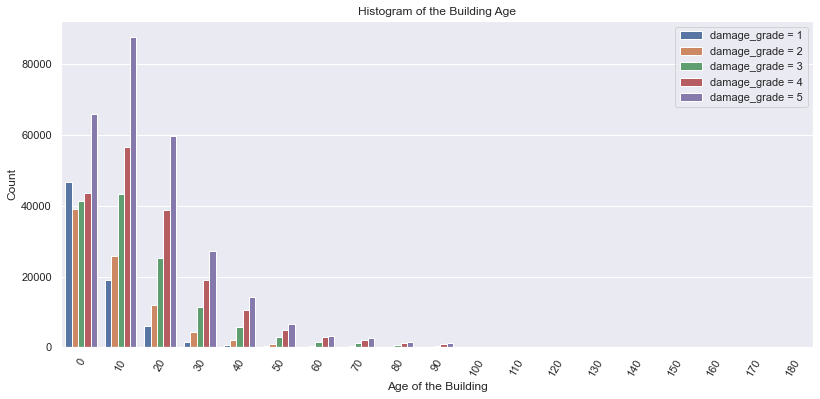

In [65]:
# Create categories to plot the data without outliers
df['age_building_cat'] = pd.cut(df['age_building'], range(0,200,10), labels = list(range(0,190,10))).copy()
plt.figure(figsize=(12,6))
sns.countplot(x=df['age_building_cat'],hue=df["damage_grade"])
plt.ylabel("Count")
plt.xlabel("Age of the Building")
plt.xticks(rotation=60)
plt.title("Histogram of the Building Age")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3", "damage_grade = 4","damage_grade = 5"], loc='upper right')
plt.show()

From the histogram, we can see that the data is still right skewed and probably contains further outliers. Lets have a look at the data using a boxplot. 

In [66]:
# Change figure size

In [67]:
plt.rcParams['figure.figsize'] = [5.0, 3.0]
#plt.rcParams['figure.dpi'] = 140

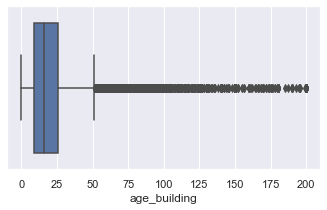

In [68]:
sns.boxplot(x = df['age_building']);

Based on the Boxplot we can see that we still have some outliers in the age_building column. We will get ride of them using the winsorize library.

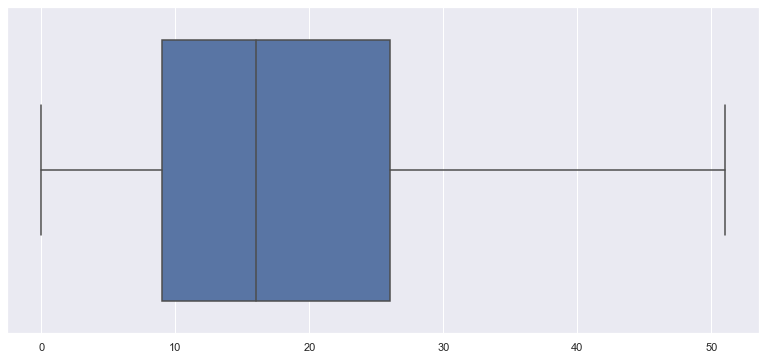

In [69]:
# Outlier removment
age_without_outlier = winsorize(df['age_building'],(0, 0.05))

# Replace data in dataset
df['age_building'] = age_without_outlier


plt.figure(figsize=(12,6))
sns.boxplot(x = age_without_outlier)
plt.show()

This worked well. We will apply the same approach to the other columns that contain outliers.

In [70]:
# Outlier removment from plinth_area_sq_ft
plinth_area_sq_ft_without_outlier = winsorize(df['plinth_area_sq_ft'],(0, 0.05))

# Replace data in dataset
df['plinth_area_sq_ft'] = plinth_area_sq_ft_without_outlier


# Outlier removment from height_ft_pre_eq
height_ft_pre_eq_without_outlier = winsorize(df['height_ft_pre_eq'],(0, 0.05))

# Replace data in dataset
df['height_ft_pre_eq'] = height_ft_pre_eq_without_outlier

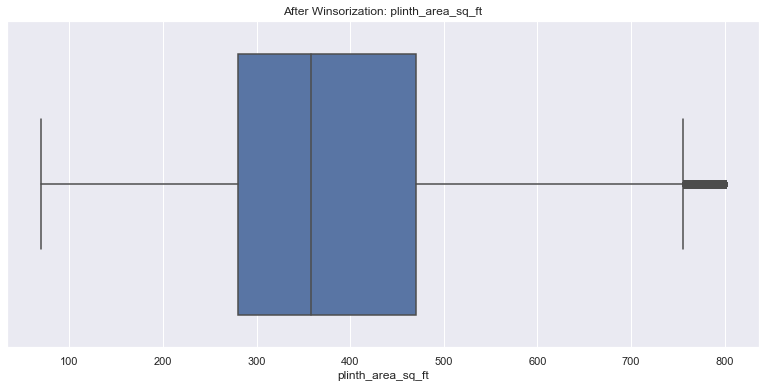

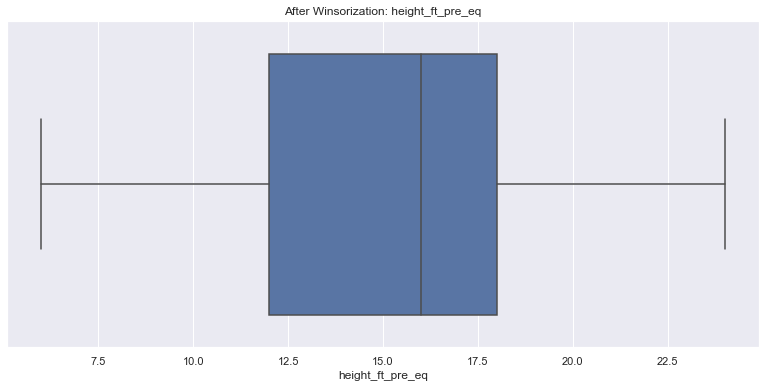

In [71]:
# Plotting variables with outliers removed. 
columns_boxplot =[ "plinth_area_sq_ft", "height_ft_pre_eq"]

for i in df[columns_boxplot]:
    plt.figure(figsize=(12,6))
    sns.boxplot(x = i, data = df[columns_boxplot])
    plt.title(f'After Winsorization: {i}')
    plt.show()

#### **Summary**:

- We removed oulier from plinth_area_sq_ft, height_ft_pre_eq and age_building.
- Overall, 3116 rows were deleted and contains 751356 rows.

### Hypotheses Exploration II

Now we come back to the hypotheses we made at the beginning. A good starting point is to use a heatmap, which shows the correlation between the grade of damage and feature variables. 

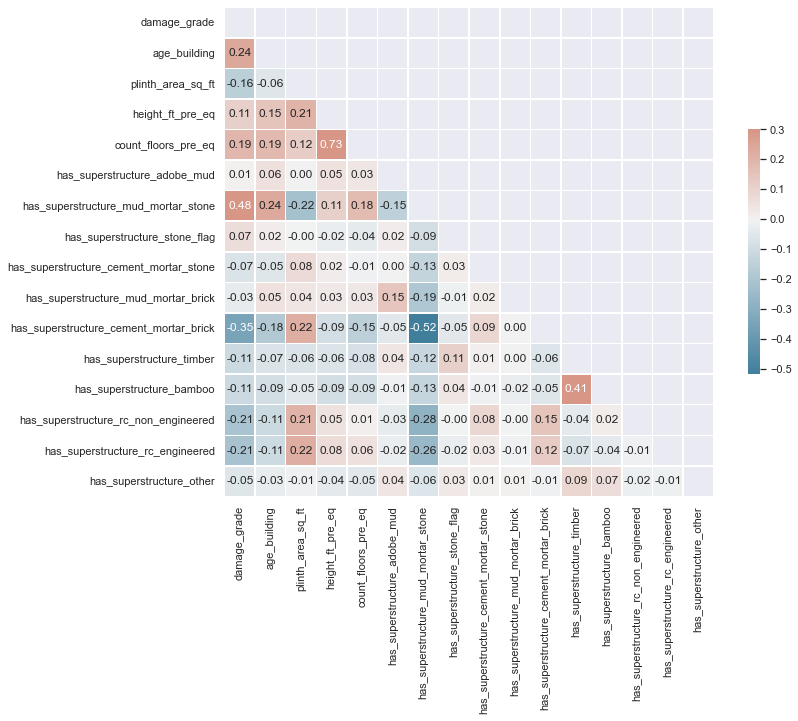

In [72]:
# Compute the correlation matrix of the target variable and most correlated features

vars_selected = ['damage_grade',
                 'age_building',
                 'plinth_area_sq_ft',
                 'height_ft_pre_eq',
                 'count_floors_pre_eq',
                 'has_superstructure_adobe_mud',
                 'has_superstructure_mud_mortar_stone',
                 'has_superstructure_stone_flag',
                 'has_superstructure_cement_mortar_stone',
                 'has_superstructure_mud_mortar_brick',
                 'has_superstructure_cement_mortar_brick',
                 'has_superstructure_timber',
                 'has_superstructure_bamboo',
                 'has_superstructure_rc_non_engineered',
                 'has_superstructure_rc_engineered',
                 'has_superstructure_other']

corr = df[vars_selected].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f');

### Summary
- After removing outliers from  from  "plinth_area_sq_ft", "height_ft_pre_eq" and "age_building" our data we can see that:
    - The height of the building now correlates more strongly with the degree of damage. 
    - The area is still negatively correlated with the degree of damage, although to a slightly lesser extent.
    - The age of the building appears to be moderately positively correlated with the degree of damage. This would support the hypothesis that the older the building, the greater the damage.

### Save the Clean Data

In [42]:
#df.to_pickle("data/clean/data_clean.csv")